<a href="https://colab.research.google.com/github/aissahm/image_analysis/blob/main/task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Task 3**

In [1]:
import numpy as np
import cv2
from skimage import segmentation
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import os
import pandas as pd

!pip install ipython-autotime
%load_ext autotime

time: 3.16 ms (started: 2021-01-07 15:32:46 +00:00)


## **Introduction**

In [2]:
#returns mask for correspoinding image
def returnMaskPathFromImagePath(imagePath):
  imagePath = imagePath.replace(" ", "")
  return imagePath.replace("orig", "mask") 

#given a text file containing the name of training images return pathfile of respective masks
def returnMaskImagesPathArray(trainTextPath):
  mask_images_path_array = []
  train_images_array = []
  with open(trainTextPath, 'r') as file:
      data = file.read().replace('\n', ';')
      train_images_array = data.split(";")
  for train_image_str in train_images_array:
    mask_image_str = train_image_str.replace("./plates/orig", "/content/plates/mask")
    if len(mask_image_str) > 0:
      mask_images_path_array.append(mask_image_str)

  return mask_images_path_array

#return the subimage of interest
def returnSubimageWith(width, height, xcenter, ycenter, maskImg):
  xstart = xcenter - width//2
  xend = xcenter + width//2
  ystart = ycenter - height//2
  yend = ycenter + height//2
  return maskImg[ystart:yend+1,xstart: xend+1,:]

#returns the number of pixels representing the plate in the mask
def returnPlateNumberPixelsFromMask(maskImg):
  #maskImg = cv2.imread(maskPath)
  return maskImg.sum()/(3*255)

#given width x height, and center coordinates of subimage, returns number of plate pixels contained in subimage
def returnPlateNumberPixelsCovBySubimage(width, height, xcenter, ycenter, maskImg):
  xstart = xcenter - width//2
  if xstart < 0:
    xstart = 0
  xend = xcenter + width//2
  ystart = ycenter - height//2
  if ystart < 0:
    ystart = 0
  yend = ycenter + height//2
  subImg = maskImg[ystart:yend+1,xstart: xend+1,:]

  return subImg.sum()/(3*255)

time: 30.3 ms (started: 2021-01-07 15:33:30 +00:00)


## **Converting original images from Grayscale to YCbCR**

In [3]:
#function that saves an image
def saveImage(image, imagefullpath):
  cv2.imwrite(imagefullpath, image)

#Mapping from grayscale pixel to RGB using color table
def fromGrayscaleToRGBMapping(pixel, H):
  V = pixel / H
  V = (6 - 2) * V + 1
  r_p = H * max(0, (3- abs(V-4) - abs(V-5))/2 )
  g_p = H * max(0, (4- abs(V-2) - abs(V-4))/2 )
  b_p = H * max(0, (3- abs(V-1) - abs(V-2))/2 )
  return [r_p, g_p, b_p]

#Transform the grayscale image with one channel into an RGB image with 3 channels
def fromGrayscaleToRGB(grayscaleimage, bits):
  if len(grayscaleimage.shape) !=2:
    print ("Error: image is not a grayscale image")
    return 0
  
  H = 2**bits -1

  #we initiate an rgb image with 3 channels with same dimensions as grayscale image
  rgbimage = np.zeros((grayscaleimage.shape[0], grayscaleimage.shape[1], 3))
  i = 0
  while i < grayscaleimage.shape[0]:
    j = 0
    while j < grayscaleimage.shape[1]:
      r_p, g_p, b_p = fromGrayscaleToRGBMapping(grayscaleimage[i][j], H)
      rgbimage[i][j][0] = r_p
      rgbimage[i][j][1] = g_p
      rgbimage[i][j][2] = b_p
      
      j +=1
    i +=1
  
  return rgbimage

#Transform an RGB image with 3 channels into a YCbCr image with 3 channels
def fromRGBToYCbCr(rgbimage, bits):
  conversionMatrix = np.array([[0.299, 0.587, 0.144], [-0.169, -0.331, 0.500], [0.500, -0.419, -0.081]])
  bias = np.array([0, 2**(bits - 1), 2**(bits -1)])
  YCbCrimage = np.zeros((rgbimage.shape[0], rgbimage.shape[1], rgbimage.shape[2]))

  i = 0
  while i < rgbimage.shape[0]:
    j = 0
    while j < rgbimage.shape[1]:
      YCbCrimage[i][j] = conversionMatrix @ rgbimage[i][j] + bias
      j += 1
    i += 1

  return YCbCrimage

#Main function that converts a grayscale image with 1 channel to a YCbCr image with 3 channels
def fromGrayscaleToYCbCr(image, bits):
  rgbimage = fromGrayscaleToRGB(image, bits)
  if len(rgbimage.shape) < 3:
    return 0
  return fromRGBToYCbCr(rgbimage, bits)

time: 59.9 ms (started: 2021-01-07 15:33:44 +00:00)


**We create the YCbCr images**

In [4]:
directory = '/content/plates/'

#creating the folder that will contain the YCbCr images
os.mkdir("ycbcrplates")

ycbcrdirectory = "/content/ycbcrplates/"

i = 0 
for filename in os.listdir(directory):
  if "orig" in filename:
    grayscaleimg = cv2.imread(directory + filename, cv2.IMREAD_GRAYSCALE)
    ycbcrimg = fromGrayscaleToYCbCr(grayscaleimg, 8)
    ycbcrimg = ycbcrimg.astype('uint8')

    ycbcrimagepath = ycbcrdirectory + filename
    cv2.imwrite(ycbcrimagepath, ycbcrimg)
    i += 1

print("Done,", i, " images from 'plates/' converted to YCbCr.")

Done, 200  images from 'plates/' converted to YCbCr.
time: 4min 21s (started: 2021-01-07 15:33:44 +00:00)


## **Converting Images from Grayscale to LAB**

In [ ]:

def fromXYZtoLAB(xyzimage):



def fromRGBtoXYZMapping(rgbpixel):
  xyzpixel = rgbpixel / 255.

  if xyzpixel[0] > 0.04045:
    xyzpixel[0] = ( ( xyzpixel[0] + 0.055 ) / 1.055 ) ** 2.4
  else:
    xyzpixel[0] = xyzpixel[0] / 12.92
  
  if xyzpixel[1] > 0.04045:
    xyzpixel[1] = ( ( xyzpixel[1] + 0.055 ) / 1.055 ) ** 2.4
  else:  
    xyzpixel[1] = xyzpixel[1] / 12.92
  
  if xyzpixel[2] > 0.04045:
    xyzpixel[2] = ( ( xyzpixel[2] + 0.055 ) / 1.055 ) ** 2.4
  else:
    xyzpixel[2] = xyzpixel[2] / 12.92

  return xyzpixel

def fromRGBtoXYZ(rgbimage):
  #we initiate an XYZ image with 3 channels with same dimensions as RGB image
  xyzimage = np.zeros((rgbimage.shape[0], rgbimage.shape[1], rgbimage.shape[2]))
  i = 0
  while i < rgbimage.shape[0]:
    j = 0
    while j < rgbimage.shape[1]:
      x_p, y_p, z_p = fromRGBtoXYZMapping(rgbimage[i][j])
      xyzimage[i][j][0] = x_p
      xyzimage[i][j][1] = y_p
      xyzimage[i][j][2] = z_p
      j +=1
    i +=1
  
  return xyzimage

#transforms the image from RGB to LAB
def fromRGBToLAB(rgbimage):



#Main function that converts a grayscale image with 1 channel to a YCbCr image with 3 channels
def fromGrayscaleToLAB(image, bits):
  rgbimage = fromGrayscaleToRGB(image, bits)
  if len(rgbimage.shape) < 3:
    return 0
  return fromRGBToLAB(rgbimage, bits)

## **Super-pixel segmentation**

In [5]:
#returns the Geo center of each super pixel contained in an image
def returnSuperPixelsGeometricCenters(labelimage):
  width = labelimage.shape[1]
  height = labelimage.shape[0]
  nSuperPixels = np.max(labelimage) + 1
  plabelCoordinates = np.zeros(nSuperPixels)

  xCoordinates = np.zeros(nSuperPixels)
  yCoordinates = np.zeros(nSuperPixels)
  nElements = np.zeros(nSuperPixels)

  i = 0
  while i < height:
    j = 0
    while j < width:
      plabel = labelimage[i][j]
      xSum = xCoordinates[plabel]
      ySum = yCoordinates[plabel]
      nLabelElements = nElements[plabel]

      xCoordinates[plabel] = xSum + j
      yCoordinates[plabel] = ySum + i
      nElements[plabel] = nLabelElements + 1  
      j += 1
    i += 1
  
  geocenters = []
  
  plabel = 0
  while plabel < nSuperPixels :
    xCenter = xCoordinates[plabel] / nElements[plabel]
    yCenter = yCoordinates[plabel] / nElements[plabel]
    geocenters.append([int(xCenter), int(yCenter)])
    plabel += 1
  
  return geocenters

#Perform Superpixel segmentation
def returnLabelsWithSuperPixelSegmentation(imagepath, numberSuperpixels):
  originalimage = cv2.imread(imagepath)
  return segmentation.slic(originalimage, n_segments=numberSuperpixels)

time: 26.8 ms (started: 2021-01-07 15:38:06 +00:00)


In [6]:
#Function that loops through the superpixels number until a plate in subimage is found 
#With threshold 
def returnMinimumSuperpixelsFor(imagepath, numberSuperpixels, width, height, threshold):
  
  subimageWithPlateFound = False

  maskPath = returnMaskPathFromImagePath(imagepath)
  
  maskImage = cv2.imread(maskPath)
  
  nPlatePixelOriginalMask = returnPlateNumberPixelsFromMask(maskImage)
  
  while subimageWithPlateFound == False:
    
    labels = returnLabelsWithSuperPixelSegmentation(imagepath, numberSuperpixels)
    labelsGeocenters = returnSuperPixelsGeometricCenters(labels)

    for labelGeocenter in labelsGeocenters:
      xCenter = labelGeocenter[0]
      yCenter = labelGeocenter[1]
      nPlatePixelsSubimage = returnPlateNumberPixelsCovBySubimage(width, height, xCenter, yCenter, maskImage)
      
      if nPlatePixelsSubimage / nPlatePixelOriginalMask >= threshold:
        subimageWithPlateFound = True
        break

    if subimageWithPlateFound == False:
      numberSuperpixels += 1
      
    #stopping algorithm if number of superpixels is too high
    #then width, height aren't adequate
    if numberSuperpixels > 100 and subimageWithPlateFound == False:
      numberSuperpixels = -1
      break

  return numberSuperpixels 

time: 17.1 ms (started: 2021-01-07 15:38:06 +00:00)


In this task 3, we reduce the number of plates pixels required to classify a subimage as class 1 "plate/foreground". In the previous tasks (1 and 3), we chose a threshold of 90%. In this task, we set the thresold to 50%. That means that every patch that contains just 50% of the plate pixels inside the patch is classified as a "plate/foreground". 

Note: We will have to take that into account when comparing the results with the classifiers we built in the previous tasks.

In [7]:
w = 100 #175 #163
h = 60 #81 #79
thresholdV = 0.5

time: 1.22 ms (started: 2021-01-07 15:38:06 +00:00)


In [ ]:
superpixelsStart = 48

platesFolderPath = "/content/plates/"

f = open("train1.txt", "r")
for imgpath in f:
  imgpath = imgpath.replace("./plates/", "")
  imgpath = imgpath.replace(" ", "")
  imgpath = platesFolderPath + imgpath
  
  if len(imgpath) > 5 and superpixelsStart > 0:
    superpixelsStart = returnMinimumSuperpixelsFor(imgpath.strip(), superpixelsStart, w, h, thresholdV)
    print(imgpath, ": ", superpixelsStart)

**Conclusion:**

Since the treshold is very low, we decided to reduce drastically the size of the patches from the previous tasks. This will decrease dramatically the computations required to process the images too. 

With trials, we found that, with a patch size of 100x60, we require 48 superpixels in order to get at least one patch classified as "plate/foreground" for each image in the three training sets. 

Those parameters will be used in the next steps.

## **Creating the subimages with chosen number of superpixels**

For the task, we use only the training set 1. We evaluate the classifier and compare it to the classifiers built in the previous tasks. 

After that, we select which classifier is the best according to the percentage of plate pixels activated and the percentage of pixels outside the plate deactivated. The higher the scores of the two metrics, the better the model.

In [8]:
def returnSubimageWIth(width, height, xcenter, ycenter, originalimage):
  xstart = xcenter - width//2
  ystart = ycenter - height//2
  xend = xcenter + width//2
  yend = ycenter + height//2

  if xstart < 0 or ystart < 0:
    print("xcoord or ycoor negative, xstart =",  xstart, ", ystart = ", ystart)
  
  return originalimage[ystart:yend+1,xstart: xend+1,:]

#verifiy the subimage fits inside the original image
def returnCenterCoordinatesSubimageInsideOrigImage(width, height, xcenter, ycenter, W, H):
  if xcenter < width // 2:
    xcenter = width // 2
    
  if xcenter >= W - width//2:
    xcenter = W - width//2 - 1

  if ycenter < height //2:
    ycenter = height //2
  
  if ycenter >= H - height//2:
    ycenter = H - height//2 - 1
  
  return [xcenter, ycenter]

#giving a name for the subimage
def returnSubimageFilename(width, height, xcenter, ycenter, subimageclass, imagepath):
  subimagefilename = imagepath.replace(".png", "")
  subimagefilename = subimagefilename + "_" + str(xcenter) + "_" + str(ycenter) + "_" + str(width) + "_" + str(height) + "_" + str (subimageclass) + ".png"
  return subimagefilename

#returns the subimage characteristics from its name
def returnSubimageDimensionsCenterCoordinates(imagename):
  imagename = imagename.replace(".png", "")
  elementsArray = imagename.split("_")
  imageID = elementsArray[1]
  width = int(elementsArray[4])
  height = int(elementsArray[5])
  xcenter = int(elementsArray[2])
  ycenter = int(elementsArray[3])
  imageclass = int(elementsArray[6])
  return [imageID, width, height, xcenter, ycenter, imageclass]

#returns the class of the subimage depending on the percentage 
#of pixel plates it contains from the original image
def returnSubimageClassWith(nPlatePixelsSubimage, nPlatePixelOriginalMask, platePixelsThreshold):
  if nPlatePixelsSubimage / nPlatePixelOriginalMask >= platePixelsThreshold:
    return 1
  return 0

#creates the subimages with a given number of superpixels
def createSubimagesWithSuperPixelsSegmentation(originalImageFolder, yCbCrImageFolder, imagename, subImageFolder, numberSuperpixels, width, height, platePixelsThreshold):
  imagepath = originalImageFolder + imagename
  yCbCrimagepath = yCbCrImageFolder + imagename
  label = returnLabelsWithSuperPixelSegmentation(imagepath, numberSuperpixels)
  labelsGeocenters = returnSuperPixelsGeometricCenters(label)
  
  maskPath = returnMaskPathFromImagePath(imagepath)
  maskImage = cv2.imread(maskPath)
  nPlatePixelOriginalMask = returnPlateNumberPixelsFromMask(maskImage)
  yCbCrOriginalImage = cv2.imread(yCbCrimagepath)

  nSubimagesCreated = 0

  W = maskImage.shape[1]
  H = maskImage.shape[0]

  subimageWithClass1 = False

  for labelGeocenter in labelsGeocenters:
    xcenter = labelGeocenter[0]
    ycenter = labelGeocenter[1]

    #we recenter the subimage if needed to fit intside the original image
    #we do that because we need to perform batch norm and we need all subimages with same dimensions
    xcenter, ycenter = returnCenterCoordinatesSubimageInsideOrigImage(width, height, xcenter, ycenter, W, H)
    nPlatePixelsSubimage = returnPlateNumberPixelsCovBySubimage(width, height, xcenter, ycenter, maskImage)
    
    #getting the class of the subimage according to the threshold of plate pixels inside it
    subimageclass = returnSubimageClassWith(nPlatePixelsSubimage, nPlatePixelOriginalMask, platePixelsThreshold)
    
    subimage = returnSubimageWIth(width, height, xcenter, ycenter, yCbCrOriginalImage)
    subimagefilename = returnSubimageFilename(width, height, xcenter, ycenter, subimageclass, imagename)
    #saving the subimage
    cv2.imwrite(subImageFolder + subimagefilename, subimage)
    nSubimagesCreated += 1

    if subimageclass == 1:
      subimageWithClass1 = True

  #we verifiy we get at least one subimage containing enough plate pixels
  if subimageWithClass1 == False:
    print("No class 1 for ", imagename)

  return nSubimagesCreated

time: 99.5 ms (started: 2021-01-07 15:38:06 +00:00)


In [9]:
number_superpixels = 48

yCbCrPlatesFolder = "/content/ycbcrplates/"
platesFolderPath = "/content/plates/"

subimageFoldernameArray = ["train1"]
traintextfilearray = ["train1.txt"]

i = 0
while i < len(traintextfilearray):
  totalSubimagesCreated = 0 
  f = open(traintextfilearray[i], "r")

  os.mkdir(subimageFoldernameArray[i])

  for imgname in f:
    imgname = imgname.replace("./plates/", "")
    imgname = imgname.replace(" ", "")

    if len(imgname) > 5:
      subimagesCreated = createSubimagesWithSuperPixelsSegmentation(platesFolderPath, yCbCrPlatesFolder, imgname.strip(), subimageFoldernameArray[i] + "/", number_superpixels, w, h, thresholdV)
      totalSubimagesCreated += subimagesCreated 

  print()
  print(traintextfilearray[i])
  print("Number of subimages created :", totalSubimagesCreated)
  i += 1


train1.txt
Number of subimages created : 3166
time: 29.8 s (started: 2021-01-07 15:38:06 +00:00)


We create the subimages for the test set 1 also.

In [10]:
subimageFoldernameArray = ["test1"]
traintextfilearray = ["test1.txt"]

i = 0
while i < len(traintextfilearray):
  totalSubimagesCreated = 0 
  f = open(traintextfilearray[i], "r")

  os.mkdir(subimageFoldernameArray[i])

  for imgname in f:
    imgname = imgname.replace("./plates/", "")
    imgname = imgname.replace(" ", "")

    if len(imgname) > 5:
      subimagesCreated = createSubimagesWithSuperPixelsSegmentation(platesFolderPath, yCbCrPlatesFolder, imgname.strip(), subimageFoldernameArray[i] + "/", number_superpixels, w, h, thresholdV)
      totalSubimagesCreated += subimagesCreated 

  print()
  print(traintextfilearray[i])
  print("Number of subimages created :", totalSubimagesCreated)
  i += 1


test1.txt
Number of subimages created : 3206
time: 29.8 s (started: 2021-01-07 15:38:36 +00:00)


We created the patches from training set 1 images, and test set 1 images. We are ready for the next step.

**Saving the patches**

In [ ]:
!zip -r /content/train1patches.zip /content/train1

In [ ]:
!zip -r /content/test1patches.zip /content/test1

## **Marker selection**

We select randomly a patch from class "plate/foreground" that we will mark.

We will conduct the following experiments:

*   select one class 1 patch and mark it (we mark only the figures appearing on the plate)
*   select one class 1 patch and mark it (we mark the border of the plate)
*   select two class 1 patch and mark them according to the best results obtained from the previous two experiments
*   select three class 1 patch and mark them according to the best results obtained from the previous two experiments

Those experiments will allow us to determine how to best mark a class 1 patch, and see how many marked patches we need to achieve the best results from the classifier.




We use an image editor to mark the patches. The results obtained are the following:

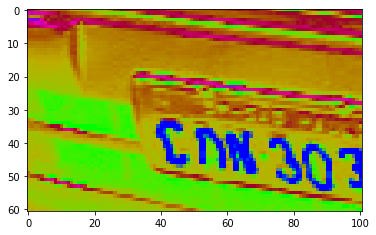

time: 168 ms (started: 2021-01-07 15:39:06 +00:00)


In [11]:
img = cv2.imread("/content/train1/orig_0003_168_160_100_60_1.png")

markedimg = cv2.imread("/content/orig_0003_168_160_100_60_1_marker.png")

plt.imshow(markedimg)
plt.show()

In [12]:
label = returnLabelsWithSuperPixelSegmentation("/content/orig_0003_168_160_100_60_1_marker.png", 48)

time: 16.6 ms (started: 2021-01-07 15:39:06 +00:00)


In [13]:
label_array = np.array([label])

time: 1.04 ms (started: 2021-01-07 15:39:06 +00:00)


## **FLIM algorithm**

We need to get the zip file of FLIM algorithm from [FLIM repository on Github](https://github.com/LIDS-UNICAMP/FLIM)

In [ ]:
!unzip "/content/FLIM-master.zip"

!pip install "/content/FLIM-master/"

!pip install -r "/content/FLIM-master/requirements.txt"

In [14]:
!unzip "/content/FLIM-dev.zip"

!pip install "/content/FLIM-dev/"

!pip install -r "/content/FLIM-dev/requirements.txt"

Archive:  /content/FLIM-dev.zip
27af84ccc3f38c6585292e4cdb121b41c50928dc
   creating: FLIM-dev/
  inflating: FLIM-dev/.gitignore     
   creating: FLIM-dev/.vscode/
  inflating: FLIM-dev/.vscode/settings.json  
  inflating: FLIM-dev/LICENSE        
  inflating: FLIM-dev/README.md      
  inflating: FLIM-dev/arch.json      
   creating: FLIM-dev/docs/
  inflating: FLIM-dev/docs/Makefile  
  inflating: FLIM-dev/docs/requirements.txt  
   creating: FLIM-dev/docs/source/
   creating: FLIM-dev/docs/source/_autosummary/
  inflating: FLIM-dev/docs/source/_autosummary/flim.models.lcn.rst  
  inflating: FLIM-dev/docs/source/_autosummary/flim.models.rst  
  inflating: FLIM-dev/docs/source/_autosummary/flim.rst  
  inflating: FLIM-dev/docs/source/_autosummary/flim.utils.label_connected_componentes.rst  
  inflating: FLIM-dev/docs/source/_autosummary/flim.utils.rst  
   creating: FLIM-dev/docs/source/_templates/
  inflating: FLIM-dev/docs/source/_templates/custom-class-template.rst  
  inflating: 

time: 40.7 s (started: 2021-01-07 15:39:06 +00:00)


In [15]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/content/FLIM-dev')


import flim as flim
from flim import utils
from flim.models import lcn

time: 3.15 s (started: 2021-01-07 15:39:46 +00:00)


In [16]:
markedimg.shape

(61, 101, 3)

time: 3.09 ms (started: 2021-01-07 15:40:28 +00:00)


In [31]:
lcnarchitecture = {"features": {
        "type": "sequential",
        "layers": {
            "conv1": {
                "operation": "conv2d",
                "params": {
                    "kernel_size": 5,
                    "stride": 1,
                    "padding": 2,
                    "dilation": 1,
                    "number_of_kernels_per_marker": 8
                },
                "activation": {
                    "operation": "relu",
                    "params": {
                        "inplace": True
                    }
                },
                "pool": {
                    "operation": "max_pool2d",
                    "params": {
                        "kernel_size": 3,
                        "stride": 4,
                        "padding": 0
                    }
                }
            },
        }
    }}


last_conv_layer_out_channels = 3
lcnmodel = lcn.LCNCreator(lcnarchitecture, [img], label_array,)

time: 9.03 ms (started: 2021-01-07 16:13:12 +00:00)


In [34]:
nnn = lcnmodel.get_LIDSConvNet()

time: 1.09 ms (started: 2021-01-07 16:14:07 +00:00)


In [35]:
nnn.train()

LIDSConvNet(
  (feature_extractor): Sequential()
  (classifier): Sequential()
)

time: 3.21 ms (started: 2021-01-07 16:14:14 +00:00)


In [40]:
nnn.__dict__

{'_backward_hooks': OrderedDict(),
 '_buffers': OrderedDict(),
 '_forward_hooks': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_logger': <RootLogger root (WARNING)>,
 '_modules': OrderedDict([('feature_extractor', Sequential()),
              ('classifier', Sequential())]),
 '_non_persistent_buffers_set': set(),
 '_parameters': OrderedDict(),
 '_remove_border': 0,
 '_state_dict_hooks': OrderedDict(),
 'training': True}

time: 2.96 ms (started: 2021-01-07 16:22:52 +00:00)
